In [1]:

import pandas as pd
import numpy as np
import plotly.express as px

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 100)

In [2]:
# updates for database and webscraping code
# TODO brand_source_id is not working - null
# TODO no actual product names in data - adjust displayname col


In [2]:
df = pd.read_csv('../data/preprocessed_data.csv')


### Day 1 - Basic scatter, mascara pricing at sephora

In [ ]:
df.loc[df['size_refinement'].isna(),'size_refinement'] = 'Standard'
mascaras = df[df['category_root_name_l3']=='Mascara']

mascaras = mascaras[~mascaras['target_url'].str.contains('serum')]
mascaras = mascaras[mascaras['unit_ml']<20]



fig = px.scatter(
    mascaras, 
    x="unit_ml", 
    y="price", 
    symbol='size_refinement', 
    color='value_CAD_ml',
    opacity=0.75,
    title='Mascara pricing at Sephora (Jan 2025)',
    color_continuous_scale=px.colors.sequential.Agsunset,
    custom_data=["brand_name", "target_url", "product_code"]  # Add additional custom data
)

fig.update_traces(
    marker=dict(
        size=12,
        line=dict(
            width=1,
            color='black'
        )
    ),
    selector=dict(mode='markers'),
    hovertemplate=(
            "<b>Product Code:</b> %{customdata[2]}<br>" +
            "<b>Brand:</b> %{customdata[0]}<br>" +
            "<b>Product URL:</b> %{customdata[1]}<br>" +
            "<b>Price (CAD):</b> %{y}<br>" +
            "<b>Volume (mL):</b> %{x}<br>" +
            "<b>Unit Price (CAD/mL):</b> %{marker.color:.2}"
    )    
)


fig.update_layout(
     font=dict(
        # family="Geist, serif",  # Font family (as defined in Google Fonts)
        size=14,                     # Font size
        color="black"                # Font color
    ),
    title=dict(
        x=0.5,
        font=dict(
            size=20
        )),
    legend=dict(
        title='Product Type',
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
    ),
    margin=dict(l=50, r=50, t=50, b=50),
    template='simple_white',
    xaxis_title="Volume (mL)", 
    yaxis_title="Price (CAD)",
    coloraxis=dict(
        colorbar=dict(
            title=dict(
                text="Unit Price <br>(CAD/mL)", 
                side="top"      
            ),
            outlinecolor="black",  
            outlinewidth=1,     
            tickcolor="black",
            tickfont=dict(color="black") 
        )
    )
)

fig.show(height=400, width=600, scale=10)

fig.write_html("../figures/dynamic/scatter_mascara_pricing.html")
fig.write_image("../figures//scatter_mascara_pricing.png", height=400, width=600, scale=10)


### Day 2 - Basic scatter, mascara pricing at sephora

In [ ]:
product_groups = mascaras.groupby(['product_code','size_refinement'], as_index=False).agg({
    'value_CAD_ml':max,
    'target_url':'first',
    'brand_name':'first',
    'parent_product_code':'first',
    'sku_id':'first'
})

product_groups = product_groups.pivot(index='product_code', columns='size_refinement', values='value_CAD_ml')

product_groups = product_groups[(product_groups['Mini'].notnull()) & (product_groups['Standard'].notnull())]

product_groups['size_ratio'] = product_groups['Mini'] / product_groups['Standard']
product_groups = product_groups.sort_values(by='size_ratio')

In [ ]:
min_value = round(np.floor(product_groups[['Mini','Standard']].min().min()))
max_value = round(product_groups[['Mini','Standard']].max().max())

equal_value_line = [x for x in range(min_value,max_value+1)]



fig = go.Figure()

fig.add_trace(go.Scatter(x=product_groups['Mini'], y=product_groups['Standard'],
                    mode='markers',
                    name='Products',
                    opacity=0.8,
                    marker=dict(
                        color='DarkBlue',
                        size=12,
                        line=dict(width=1,
                                        color='white')
                    ),
                    ))
fig.add_trace(go.Scatter(x=equal_value_line, y=equal_value_line,
                    mode='lines',
                    name='Equal Value',
                    marker=dict(
                        color='RoyalBlue',
                    ),

                    opacity=0.5))


product_annotations = {
    'P111902':'Tarte, Lights Camera Lashes',
    'P466443':'Sephora Collection, Size Up Mascara',
    'P128706':'Lancôme, Clis Booster XL Super Enhancing Mascara Base'
}


fig.add_annotation(x=5.750000, y=8.181818,
            text="Lancôme<br>Clis Booster XL Super Enhancing Base",
            showarrow=True,
            arrowhead=1,
            ax=20,
            ay=-25)

fig.add_annotation(x=4.200000, y=5.285714,
            text="Tarte<br>Lights Camera Lashes",
            showarrow=True,
            arrowhead=1,
            ax=20,
            ay=-25)

fig.add_annotation(x=1.690674, y=1.259013,
            text="Sephora Collection<br>Size Up",
            showarrow=True,
            arrowhead=1,
            ax=20,
            ay=25,
            )


# Line of best fit 

model = LinearRegression()
model.fit(product_groups['Mini'].values.reshape(-1, 1), product_groups['Standard'].values.reshape(-1, 1) )

x_range = np.linspace(min_value, max_value+1, 50)
y_range = model.predict(x_range.reshape(-1, 1))

b_0 = model.intercept_[0]
b_1 = model.coef_[0][0]
equation = f"y={b_0:.2f}{b_1:+.2f}x"
fig.add_trace(go.Scatter(x=np.hstack(x_range), y=np.hstack(y_range),
                    mode='lines',
                    name=equation))

fig.update_layout(
    margin=dict(l=50, r=50, t=50, b=50),
    template='simple_white',
    yaxis_range=[0,10],
    xaxis_range=[0,10],
    yaxis_title="Mini Size Unit Price (CAD/mL)",
    xaxis_title="Standard Size Unit Price (CAD/mL)",
    title=dict(
    text='Unit Prices of Mascaras with Standard and Mini variations<br><sup>Mini size products under the Equal Value curve are cheaper than Standard size versions</sup>',
    x=0.5,
    font=dict(
        size=20
    )),
)

fig.show()
fig.write_image("../figures/scatter_mascara_mini_standard.png", scale=10)


### Day 3, 

In [ ]:
brand_prices = df.groupby(['brand_name','product_code','category_root_name_l1'],as_index=False).agg({
    'price':'mean',
    'rating':'mean',
    'reviews':'mean',
    'loves_count':'mean'
})
brand_prices=brand_prices[brand_prices['price']>1]


# brand_prices = brand_prices[(brand_prices['reviews']>=0) & (brand_prices['category_root_name_l1']=="Fragrance")]

# product_limit = 20
# brand_size = brand_prices.groupby('brand_name')['product_code'].count()
# brand_size = brand_size[brand_size>product_limit].index

# brand_prices = brand_prices[brand_prices['brand_name'].isin(brand_size)]

In [ ]:
fig = go.Figure()
#     title=,

fig.add_trace(go.Scattergl(
    y=brand_prices['loves_count'], 
    x=brand_prices['price'], 
    marker_color=brand_prices['reviews'],
    mode='markers',
    name='Products',
    marker=dict(
        colorscale='Plotly3',
        size=12,
        opacity=0.75,
        showscale=True,
        colorbar=dict(
            title=dict(
                text="Reviews",
                font=dict(size=12)
            )
        )
    ),

    ),
)
fig.add_annotation(x=32.500000, y=3183836.0,
            text="1. Summer Fridays,<br>Lip Butter Balm",
            showarrow=True,
            arrowhead=1,
            ax=20,
            ay=25)


fig.add_annotation(x=32.666667, y=1755189.0,
            text="2. LANEIGE, Lip<br>Sleeping Mask",
            showarrow=True,
            arrowhead=1,
            ax=40,
            ay=-45)


fig.add_annotation(x=32.50, y=1587086.0,
            text="3. NARS, Creamy<br>Radiant Concealer",
            showarrow=True,
            arrowhead=1,
            ax=-60,
            ay=-35)

fig.add_annotation(x=53, y=1580169.0,
            text="4. PATRICK TA, Major<br>Headlines Double-Take Palette",
            showarrow=True,
            arrowhead=1,
            ax=100,
            ay=-10)
# PATRICK TA 

fig.update_layout(
    margin=dict(l=50, r=50, t=50, b=50),
    template='simple_white',
    yaxis_title="'Loves'",
    xaxis_title="Price (CAD)",
    title=dict(
    text="Cult classic ranking with Sephora 'Loves'<br><sup>Summer Fridays Lip Butter has been added to 'Loves' list by over 3M</sup>",
    x=0.5,
    font=dict(
        size=20
    ))
    
)

fig.show()
fig.write_image("../figures/scatter_all_products_loves_price_rating.png", scale=5)

In [193]:
df.groupby('brand_name')['product_code'].nunique().sort_values(ascending=False).head(20)

brand_name
Davines                    59
Moroccanoil                57
Dermalogica                56
TOM FORD                   56
Clarins                    53
Kérastase                  53
Lise Watier                53
Fenty Beauty by Rihanna    52
The Ordinary               52
Gucci                      51
Living Proof               51
MAC Cosmetics              51
Oribe                      51
CLINIQUE                   50
NEST New York              50
tarte                      50
Benefit Cosmetics          50
Yves Saint Laurent         50
Bumble and bumble          49
shu uemura                 49
Name: product_code, dtype: int64

In [161]:
df.brand_name.value_counts()
cat1_filter = df['category_root_name_l1'].isin(['Men','Gifts'])
cat2_filter = df['category_root_name_l2'].isin([['Shop by Concern', 'Unisex / Genderless', 'By Category']])

brands = ['TOM FORD','Kérastase','Fenty Beauty by Rihanna',
          'The Ordinary','CLINIQUE']
brand_filter = df['brand_name'].isin(brands)
brand_profile = df[(brand_filter) & (~cat1_filter)].groupby(['brand_name','category_root_name_l1'], as_index=False)['product_code'].nunique()

brand_profile['total_products'] = brand_profile.groupby(['brand_name'])['product_code'].transform(sum)
brand_profile['product_proportion'] = brand_profile['product_code'] / brand_profile['total_products']
l2_categories = brand_profile['category_root_name_l1'].unique()
brand_profile = brand_profile.pivot(index='category_root_name_l1', columns='brand_name', values='product_proportion').fillna(0.0)

/var/folders/kr/73vbzj0d1_v9p45z5knxvq5h0000gn/T/ipykernel_4750/408921281.py:10: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  brand_profile['total_products'] = brand_profile.groupby(['brand_name'])['product_code'].transform(sum)


### Day 4 spider plots

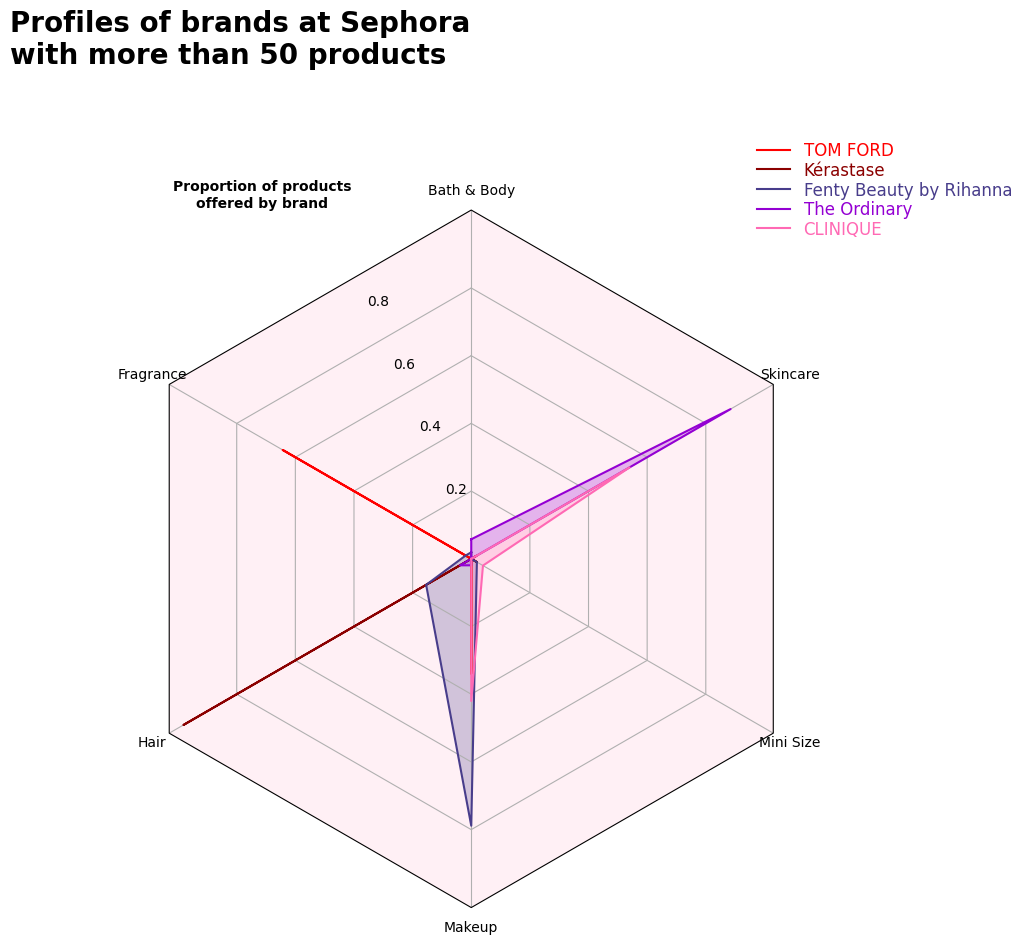

In [227]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


data = [
        brand_profile.index.values,
        [brand_profile[brand].values for brand in brands],
    ]
N = brand_profile.index.shape[0]

theta = radar_factory(N, frame='polygon')

spoke_labels = data[0]

fig, ax = plt.subplots(figsize=(9, 9), 
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
ax.set_facecolor('lavenderblush')


colors = ['red',  'darkred', 'darkslateblue', 'darkviolet','hotpink']

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_title("Proportion of products\noffered by brand", weight='bold', size='medium', position=(0.2, 1.4),
                verticalalignment='center')

for d, color in zip(data[1], colors):
    ax.plot(theta, d, color=color)

    ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
labels = tuple(brands)
legend = ax.legend(labels, loc=(0.9, .95), labelcolor=colors,fancybox=False,edgecolor='white',
                            labelspacing=0.1, fontsize='large')

fig.text(0, 1, 'Profiles of brands at Sephora\nwith more than 50 products', fontsize=20,
             color='black', weight='bold')

# plt.show()
plt.savefig('../figures/spider_plot_brand_profiles.png', bbox_inches='tight')
